<a href="https://colab.research.google.com/github/JAYATIS23/Object-detection-and-tracking/blob/main/VEHICLEDETETCTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install YOLOv8
!pip install ultralytics -q

from google.colab import files
import zipfile, os

print("Upload your ZIP dataset:")
uploaded = files.upload()

# Extract ZIP
zip_filename = list(uploaded.keys())[0]
extract_path = "my_dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.5 MB/s eta 0:00:00
Upload your ZIP dataset:


Saving detection_vehicles.v3-try_vehicle.yolov8.zip to detection_vehicles.v3-try_vehicle.yolov8.zip
Dataset extracted to: my_dataset


In [ ]:
from google.colab import files
import os

print("Upload your VIDEO file (mp4/avi/mov):")
uploaded_video = files.upload()

video_path = list(uploaded_video.keys())[0]
print("Using video:", video_path)
print("Full path:", os.path.abspath(video_path))


Upload your VIDEO file (mp4/avi/mov):


Saving videoplayback.mp4 to videoplayback.mp4
Using video: videoplayback.mp4
Full path: /content/videoplayback.mp4


In [ ]:
import cv2
from ultralytics import YOLO
import math
import numpy as np
import pandas as pd
import os

# Load YOLO model
model = YOLO("yolov8n.pt")   # you can change to yolov8s.pt etc.

# Open video
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0:
    fps = 25

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video
out_filename = "output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_filename, fourcc, fps, (w, h))

print("Saving to:", out_filename)

# Speed + overspeed settings
PIXELS_TO_METERS = 0.05
SPEED_LIMIT_KMH = 60

previous_positions = {}
speeds = {}
vehicle_classes = ["car", "bus", "truck", "motorcycle","ambulance"]

# Simple vertical lanes (3-lane example)
LANE_BOUNDS_X = [
    (0, w // 3),
    (w // 3, 2 * w // 3),
    (2 * w // 3, w)
]

def get_lane_id(cx):
    for i, (x1, x2) in enumerate(LANE_BOUNDS_X):
        if x1 <= cx < x2:
            return i
    return None

def estimate_density_level(count):
    if count <= 3:
        return "Low"
    elif count <= 7:
        return "Medium"
    else:
        return "High"

def extract_plate_roi(frame, x1, y1, x2, y2):
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(frame.shape[1]-1, x2)
    y2 = min(frame.shape[0]-1, y2)

    veh_roi = frame[y1:y2, x1:x2]
    if veh_roi.size == 0:
        return None

    h, w = veh_roi.shape[:2]
    px1 = int(w * 0.25)
    px2 = int(w * 0.75)
    py1 = int(h * 0.6)
    py2 = int(h * 0.95)
    plate = veh_roi[py1:py2, px1:px2]

    return plate if plate.size > 0 else None


# Logging for dashboard
log_rows = []
frame_index = 0
os.makedirs("overspeed_plates", exist_ok=True)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_index += 1
    results = model.track(frame, persist=True)
    r = results[0]
    annotated = r.plot()
    names = r.names

    frame_count = 0
    lane_counts = [0, 0, 0]
    overspeed_this_frame = 0

    for box in r.boxes:
        cls = names[int(box.cls[0])]
        if cls not in vehicle_classes:
            continue

        frame_count += 1
        if box.id is None:
            continue

        track_id = int(box.id[0])

        x1, y1, x2, y2 = box.xyxy[0]
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2

        # Lane assignment
        lane_id = get_lane_id(cx)
        if lane_id is not None:
            lane_counts[lane_id] += 1

        # Speed calculation
        if track_id in previous_positions:
            px, py = previous_positions[track_id]
            dist_pixels = math.hypot(cx - px, cy - py)
            meters = dist_pixels * PIXELS_TO_METERS
            speed_kmh = meters * fps * 3.6
            speeds[track_id] = speed_kmh
        previous_positions[track_id] = (cx, cy)

        # Draw speed + overspeed
        if track_id in speeds:
            sp = speeds[track_id]
            color = (0, 255, 0)

            if sp > SPEED_LIMIT_KMH:
                overspeed_this_frame += 1
                color = (0, 0, 255)

                # Save plate
                plate = extract_plate_roi(frame, x1, y1, x2, y2)
                if plate is not None:
                    cv2.imwrite(f"overspeed_plates/plate_f{frame_index}_id{track_id}.jpg", plate)

                cv2.putText(annotated, "OVERSPEED",
                            (int(cx), int(cy) + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

            lane_label = f"L{lane_id+1}" if lane_id is not None else ""
            cv2.putText(annotated, f"{lane_label} | {sp:.1f} km/h",
                        (int(cx), int(cy) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Lane density text
    for i, (x1, x2) in enumerate(LANE_BOUNDS_X):
        cv2.line(annotated, (x2, 0), (x2, h), (255, 255, 255), 1)
        cv2.putText(annotated,
                    f"Lane {i+1}: {lane_counts[i]} ({estimate_density_level(lane_counts[i])})",
                    (10, 60 + 30*i),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    # Vehicle count
    cv2.putText(annotated, f"Vehicles this frame: {frame_count}",
                (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0, 255, 0), 2)

    out.write(annotated)

    # Log data
    log_rows.append({
        "frame": frame_index,
        "lane1": lane_counts[0],
        "lane2": lane_counts[1],
        "lane3": lane_counts[2],
        "total": frame_count,
        "overspeed": overspeed_this_frame
    })

cap.release()
out.release()

df = pd.DataFrame(log_rows)
df.to_csv("traffic_log.csv", index=False)

print("Processing Complete")
print("Dashboard log saved as traffic_log.csv")


Streaming output truncated to the last 5000 lines.

0: 384x640 9 cars, 1 bus, 2 trucks, 7.1ms
Speed: 1.2ms preprocess, 7.1ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 3 trucks, 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 4 trucks, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 cars, 1 bus, 2 trucks, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 6.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 2 trucks, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 6.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 cars, 1 bus, 1 truck, 6.0ms
Speed: 2.1ms preprocess, 6.0ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 cars, 2 trucks, 6.9ms
Speed: 1.2ms preprocess, 6.9ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 64

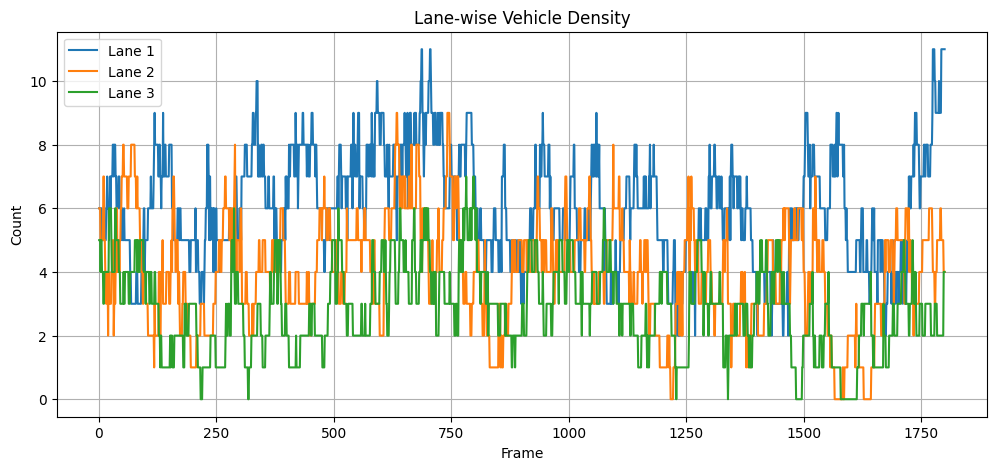

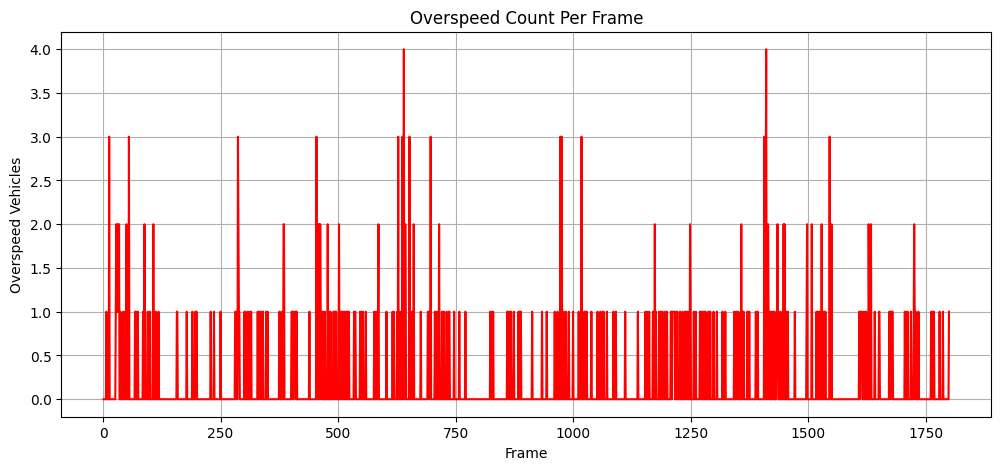

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("traffic_log.csv")

# Lane density graph
plt.figure(figsize=(12,5))
plt.plot(df["frame"], df["lane1"], label="Lane 1")
plt.plot(df["frame"], df["lane2"], label="Lane 2")
plt.plot(df["frame"], df["lane3"], label="Lane 3")
plt.legend(); plt.grid(True)
plt.xlabel("Frame"); plt.ylabel("Count")
plt.title("Lane-wise Vehicle Density")
plt.show()

# Overspeed graph
plt.figure(figsize=(12,5))
plt.plot(df["frame"], df["overspeed"], color='red')
plt.xlabel("Frame"); plt.ylabel("Overspeed Vehicles")
plt.title("Overspeed Count Per Frame")
plt.grid(True)
plt.show()


In [ ]:
from google.colab import files
files.download("output_video.mp4")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>